In [1]:
# DATA

import yfinance as yf
import numpy as np
import matplotlib as mp
import pandas as pd
import os

In [2]:
# Carnival Corporation & plc (CCL): the world’s largest leisure travel company

CCL_12M = yf.download("CCL", start="2020-03-01", end="2021-03-01") 

[*********************100%***********************]  1 of 1 completed


In [3]:
CCL_12M.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,32.709999,33.060001,31.25,33.060001,33.060001,19716200
2020-03-03,33.020000,33.340000,31.16,31.830000,31.830000,19720600
2020-03-04,32.250000,32.459999,30.90,32.459999,32.459999,19503500
2020-03-05,30.910000,30.910000,27.65,27.870001,27.870001,33085000
2020-03-06,26.910000,29.299999,26.10,27.150000,27.150000,29767800


In [4]:
CCL_12M.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-22,25.139999,27.330000,24.650000,25.969999,25.969999,87361900
2021-02-23,25.080000,26.730000,23.459999,26.459999,26.459999,115819500
2021-02-24,27.090000,28.180000,26.730000,27.010000,27.010000,92985300
2021-02-25,27.910000,28.240000,25.070000,25.469999,25.469999,71020500
2021-02-26,25.889999,26.860001,25.270000,26.750000,26.750000,57944500


In [5]:
CCL_12M['Adj Close'].tail(130) # CCL_6M 

Date
2020-08-21    14.650000
2020-08-24    16.139999
2020-08-25    15.890000
2020-08-26    15.280000
2020-08-27    16.120001
                ...    
2021-02-22    25.969999
2021-02-23    26.459999
2021-02-24    27.010000
2021-02-25    25.469999
2021-02-26    26.750000
Name: Adj Close, Length: 130, dtype: float64

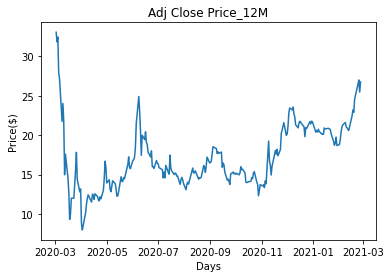

In [6]:
import matplotlib.pyplot as plt # Movement of the stock Adj Close price (12M)
fig = plt.figure()
plt.plot(CCL_12M['Adj Close'])
plt.xlabel('Days')
plt.ylabel('Price($)')
plt.title('Adj Close Price_12M');

In [7]:
log_return = [] # log returns used instead of normal returns to calculate volatility
for i in range(0,len(CCL_12M)-1):
    adjclose_yesterday = CCL_12M.iloc[i]['Adj Close']
    adjclose_today = CCL_12M.iloc[i+1]['Adj Close']
    y = np.log(adjclose_today / adjclose_yesterday)
    log_return.append(y)
log_return[:5]

[-0.0379148950351484,
 0.01959929498457709,
 -0.15245766227537358,
 -0.026173839276791473,
 -0.22222316116457402]

In [8]:
CCL_12Mlr = pd.DataFrame(log_return, columns = ['log_12M'])
lr12M = CCL_12Mlr.mean() * len(CCL_12Mlr)
lv12M = CCL_12Mlr.std() * (len(CCL_12Mlr) ** 0.5)
print('The annualized log return is %.8f and its volatility over  12 months is %.8f' % (lr12M, lv12M))

The annualized log return is -0.21178966 and its volatility over  12 months is 1.24159760


In [9]:
CCL_6Mlr = pd.DataFrame(log_return[130:-1], columns = ['log_6M']) # log returns from 2020-09-01
lr6M = CCL_6Mlr.mean() * len(CCL_12Mlr)
lv6M = CCL_6Mlr.std() * (len(CCL_12Mlr) ** 0.5)
print('The annualized log return is %.8f and its volatility over 6 months is %.8f' % (lr6M, lv6M))

The annualized log return is 0.77886423 and its volatility over 6 months is 0.83191511


In [10]:
# Cash-or-Nothing Binary put option (ETSY)
# Pricing methods

# 1 Binomial Tree Method

S0 = 30
K = 28
T = 1/12
r = 0.0171 # dated 19-03-2021
sigma = 1 # from calculated volatility (prior 6M period)
N = 3
payoff = "put"

In [11]:
dT = float(T) / N
u = np.exp(sigma * np.sqrt(dT))
d = 1 / u

In [12]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
S

array([[30.        , 35.44081239, 41.86837275, 49.46163812],
       [ 0.        , 25.39445175, 30.        , 35.44081239],
       [ 0.        ,  0.        , 21.49593932, 25.39445175],
       [ 0.        ,  0.        ,  0.        , 18.19591979]])

In [13]:
a = np.exp(r * dT)    # risk-free rate (compounded)
p = (a - d)/ (u - d)  # up
q = 1 - p           # down
p

0.45984827780748966

In [14]:
S_T = S[:,-1]
S_T

array([49.46163812, 35.44081239, 25.39445175, 18.19591979])

In [15]:
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.heaviside(S_T - K >0, 0.0)
elif payoff =="put":
    V[:,-1] = np.heaviside(K - S_T >0, 0.0)
V

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [16]:
for j in range(N - 1, -1, -1):
    for i in range(j + 1):
        V[i, j] = np.exp(- r * dT) * (p * V[i, j + 1] + q * V[i + 1, j + 1])
V

array([[0.55930055, 0.29148684, 0.        , 0.        ],
       [0.        , 0.7877908 , 0.53989521, 0.        ],
       [0.        , 0.        , 0.99952511, 1.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [17]:
print('Binary ' + payoff, str( V[0,0]))

Binary put 0.5593005498058776


In [18]:
# Cash-or-Nothing Binary put option (ETSY)

# 2 MONTE CARLO SIMULATION 

def mcs_simulation_np(m,n):  # m is 90 STEPS and n 10000 simulations
    M = m
    I = n
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [19]:
S = mcs_simulation_np(90,10000)

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

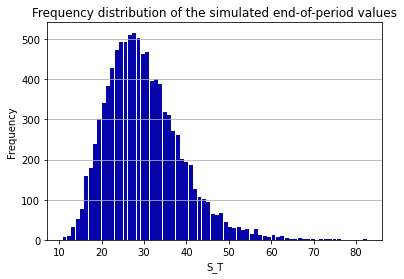

In [20]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[-1,:], bins='auto', color='#0504aa',alpha=1.0, rwidth=0.90)

plt.grid(axis='y', alpha=1.0)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

In [21]:
pp = (K - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Monte Carlo: Binary put', str(bpp))

Monte Carlo: Binary put 0.4624


In [22]:
# 2 BLACK-SCHOLES METHOD

import scipy.stats as si

In [23]:
def binary_option_BS(S, K, T, r, sigma, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        option_value = np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) # binary call option value
    elif payoff == "put":
        option_value = np.exp(-r * T) * (1 - si.norm.cdf(d2, 0.0, 1.0)) # binary put option value
    
    return option_value

In [24]:
binary_option_BS(30, 28, 1/12, 0.0171, 1, "put")

0.4596765940012547

In [25]:
S = np.linspace(0.5,75,11)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = binary_option_BS(S[i], 28, 1/12, 0.0171, 0.8, "put") 

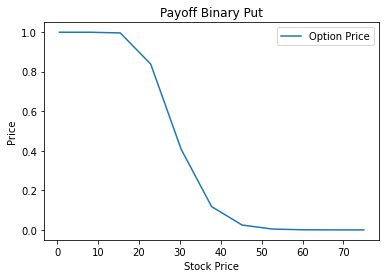

In [26]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('Payoff Binary Put')
plt.legend(['Option Price'])

In [27]:
# ANALYSIS

# GREEKS

# DELTA: rate of change of hypothetical option value with respect to changes in the underlying asset price

def delta(S, K, T, r, sigma, payoff):
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) / (sigma * (S) * np.sqrt(T))
    elif payoff == "put":
        delta = - np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) / (sigma * (S) * np.sqrt(T))
    return delta

In [28]:
delta(30, 28, 1/12, 0.0171, 1, "put")

-0.045772702508652

In [29]:
S = np.linspace(0.5,75,11)
Delta_Put = np.zeros((len(S), 1))
for i in range(len(S)):
    Delta_Put [i] = delta(S[i], 28, 1/12, 0.0171, 1, "put") 

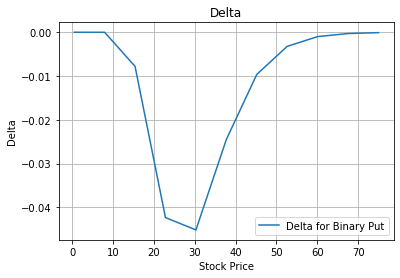

In [30]:
fig = plt.figure()
plt.plot(S, Delta_Put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Binary Put'])

In [31]:
# GAMMA: rate of change in the delta with respect to changes in the underlying price

def gamma(S, K, T, r, sigma, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        gamma = - np.exp(-r * T) * d1 * si.norm.pdf(d2, 0.0, 1.0) / ((sigma ** 2) * (S ** 2)) * (np.sqrt(T))
    elif payoff == "put":
        gamma = np.exp(-r * T) * d1 * si.norm.pdf(d2, 0.0, 1.0) / ((sigma ** 2) * (S ** 2)) * (np.sqrt(T))
    return gamma

In [32]:
gamma(30, 28, 1/12, 0.0171, 1, "put")

4.936741461149081e-05

In [33]:
S = np.linspace(0.5,75,11)
Gamma_put = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma_put [i] = gamma(S[i], 28, 1/12, 0.0171, 1, "put")

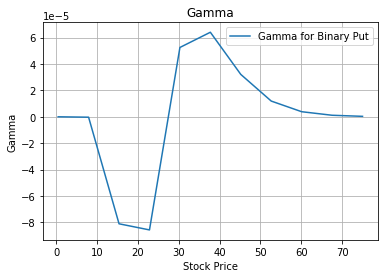

In [34]:
fig = plt.figure()
plt.plot(S, Gamma_put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Binary Put'])

In [35]:
# THETA: measures the sensitivity of the value of the derivative to the passage of time (see Option time value): the "time decay"

def theta(S, K, T, r, sigma, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        theta = (r * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) + np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0)) * ((d1 / 2 * T) - (r / sigma * np.sqrt(T)))
    elif payoff == "put":
        theta = (r * np.exp(-r * T) * (1 - si.norm.cdf(d2, 0.0, 1.0)) - np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0)) * ((d1 / 2 * T) - (r / sigma * np.sqrt(T)))
    return theta

In [36]:
theta(30, 28, 1/12, 0.0171, 1, "put")

-0.0043678674777361945

In [37]:
T = np.linspace(0.01,1,11)
Theta_put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_put [i] = theta(30, 28, T[i], 0.0171, 1, "put")

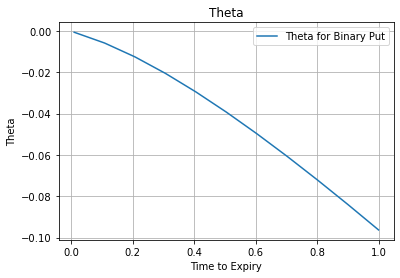

In [38]:
fig = plt.figure()
plt.plot(T, Theta_put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Binary Put'])

In [39]:
# SPEED: measures the rate of change in Gamma with respect to changes in the underlying price

def speed(S, K, T, r, sigma, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        speed = - np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) / ((sigma ** 2) * (S ** 3) * np.sqrt(T)) * ((-2 * d1) + (1 - (d1 * d2)) / (sigma * np.sqrt(T)))
    elif payoff == "put":
        speed = np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) / ((sigma ** 2) * (S ** 3) * np.sqrt(T)) * ((-2 * d1) + (1 - (d1 * d2)) / (sigma * np.sqrt(T)))
    return speed

In [40]:
speed(30, 28, 1/12, 0.0171, 1, "put")

0.00012987229369526074

In [41]:
S = np.linspace(5,75,11)
Speed_put = np.zeros((len(S),1))
for i in range(len(S)):
    Speed_put [i] = speed(S[i], 28, 1/12, 0.0171, 1, "put")

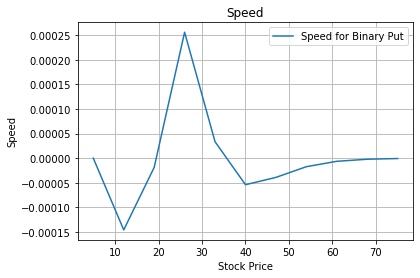

In [42]:
fig = plt.figure()
plt.plot(S, Speed_put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Binary Put'])

In [43]:
# VEGA: measures sensitivity to volatility

def vega(S, K, T, r, sigma, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        vega = - np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) * (d1 / sigma)
    elif payoff == "put":
        vega = np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0) * (d1 / sigma)
    return vega

In [44]:
vega(30, 28, 1/12, 0.0171, 1, "put")

0.15391236662175645

In [45]:
sigma = np.linspace(0.5,1.5,10)
Vega_put = np.zeros((len(sigma),1))
for i in range(len(sigma)):
    Vega_put [i] = vega(30, 28, 1/12, 0.0171, sigma[i], "put")

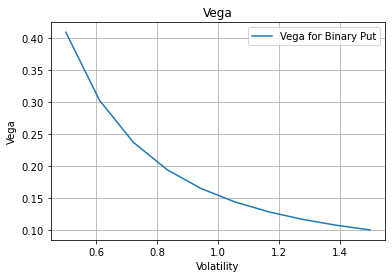

In [46]:
fig = plt.figure()
plt.plot(sigma, Vega_put, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Binary Put'])

In [47]:
# RHO: measures sensitivity to the interest rate

def rho(S, K, T, r, sigma, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
        rho =  - T * np.exp(-r * T) * si.norm.cdf(d2) + ((np.sqrt(T) / sigma) * (np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0)))
    elif payoff == "put":
        rho =  - T * np.exp(-r * T) * (1 - si.norm.cdf(d2)) - ((np.sqrt(T) / sigma) * (np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0)))
    return rho

In [48]:
rho(30, 28, 1/12, 0.0171, 1, "put")

-0.15273813910506787

In [49]:
r = np.linspace(0,0.5,10)
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Put [i] = rho(30, 28, 1/12, r[i], 1, "put")

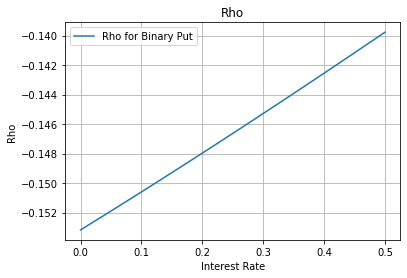

In [50]:
fig = plt.figure()
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Binary Put'])